# Data and Setting

In [26]:
import pandas as pd
from collections import defaultdict
import numpy as np
import random
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

### Network

In [27]:
#dataframe for the network 

#names of columns
cols = ['edge_ID','source','target']

#loading Dataframe
df_edges = pd.read_csv('wikigraph_reduced.csv', delimiter = '\t',names = cols).drop(index = 0)

#making edge_ID as int
df_edges['edge_ID'] = list(map(int, df_edges['edge_ID']))

df_edges


,edge_ID,source,target
1,796,95,1185516
2,909,108,1059989
3,910,108,1062426
4,911,108,1161925
5,1141,134,541222
...,...,...,...
483090,28511768,1791481,1060990
483091,28511769,1791481,1061382
483092,28511771,1791481,1110380
483093,28511772,1791482,80740


In [28]:
#tryng to calculate in-degree from the DataFrame
df_edges.groupby('target').count().mean()

edge_ID    6.401394
source     6.401394
dtype: float64

### Page Names

In [29]:
df_names = pd.read_csv('wiki-topcats-page-names.txt.gz',delimiter = '\t',names =['node name'])

In [30]:
df_names['node'] = [s.split()[0] for s in list(df_names['node name']) ]
df_names['name'] = [' '.join(s.split()[1:]) for s in list(df_names['node name'])]
df_names = df_names.drop('node name',axis = 1)

In [31]:
pages = df_names['node']

In [32]:
df_names

,node,name
0,0,Chiasmal syndrome
1,1,Kleroterion
2,2,Pinakion
3,3,LyndonHochschildSerre spectral sequence
4,4,Zariski's main theorem
...,...,...
1791484,1791484,Noadiah Russell (Yale founder)
1791485,1791485,Cornus officinalis
1791486,1791486,Peter Grummitt
1791487,1791487,Baron Estcourt


### Categories

In [33]:
names = ['cat_name','pages']
df_cat = pd.read_csv('wiki-topcats-categories.txt.gz',sep = ';',names = names)

df_cat['cat_name'] = df_cat.apply(lambda x: x['cat_name'][9:],axis = 1)

df_cat['pages'] = df_cat.apply(lambda x: x['pages'].split(),axis = 1)

df_cat

,cat_name,pages
0,Buprestoidea,"[301, 302, 303, 304, 305, 306, 307, 308, 309, ..."
1,People_from_Worcester,"[1056, 1057, 1058, 1059, 1060, 60971, 76515, 7..."
2,Skin_conditions_resulting_from_physical_factors,"[971, 973, 1166, 1167, 1168, 1169, 1170, 1171,..."
3,Visual_kei_bands,"[1297, 1300, 1311, 1312, 1313, 1314, 1315, 131..."
4,Japanese_rock_music_groups,"[1297, 1300, 1313, 1314, 1315, 1316, 1319, 132..."
...,...,...
17359,British_science_fiction_novels,"[16110, 24545, 39814, 67923, 108629, 108630, 1..."
17360,Television_soundtracks,"[1117, 110192, 110376, 110377, 110380, 110395,..."
17361,Diptera_of_North_America,"[279, 280, 283, 31110, 31129, 31133, 31138, 31..."
17362,Diptera_of_Asia,"[279, 31129, 31133, 31134, 31135, 31136, 31137..."


In [34]:
len(df_cat['cat_name'])

17364

In [35]:
#in order to remove the pages belonging to multiple categories, I made an inverted index key: Page, values: Categories in which the pages appears.
#than I randomly sampled the values in uniform way and built the dataframe again

categories = list(df_cat['cat_name'])
pages_for_cat =list(df_cat['pages'])


d_page_cat = defaultdict(list)
for i,cat in enumerate(categories):
    for pag in pages_for_cat[i]:
        d_page_cat[pag].append(cat)
    



In [36]:
list(d_page_cat.keys())[:10]

['301', '302', '303', '304', '305', '306', '307', '308', '309', '310']

In [37]:
d_random_cat_page = defaultdict(list)

for page in d_page_cat.keys():
    cat_of_page = random.sample(set(d_page_cat[page]),1)
    d_random_cat_page[cat_of_page[0]].append(page)

In [38]:
#some categories has been removed, since there is no pages in it or all the pages are other categories
new_df_cat = pd.DataFrame()
new_df_cat['cat_name'] = d_random_cat_page.keys()
new_df_cat['pages'] = d_random_cat_page.values()
new_df_cat

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,cat_name,pages
0,Buprestoidea,"[301, 302, 304, 305, 306, 307, 308, 309, 310, ..."
1,Insect_families,"[303, 1696086, 14955, 31215, 31178, 624917, 16..."
2,Year_of_birth_missing,"[1056, 781589, 289081, 1247452, 1414158, 12624..."
3,English_Anglican_priests,"[1057, 1390440, 885549, 156668, 184229, 63402,..."
4,British_writers,"[1058, 1141934, 42935, 1046888, 790501, 166650..."
...,...,...
17351,Municipalities_in_Navarre,"[130269, 444707, 445210, 445236, 1781153, 1781..."
17352,Municipalities_of_South_Tyrol,"[215159, 443945, 943609, 1781498, 1781519, 178..."
17353,Suburbs_of_Canberra,"[1781950, 1781953, 1781955, 1781959, 1781960, ..."
17354,Redirects_from_UK_postcode_districts,"[1640637, 1640638, 1788784, 1788785]"


In [39]:
s1 = set(new_df_cat['cat_name'])
s2 = set(df_cat['cat_name'])
s2.difference(s1)

{'Colostethus',
 'Days_in_2004',
 'Disused_railway_stations_in_Pomeranian_Voivodeship',
 'Populated_places_in_Bac_Kan_Province',
 'Populated_places_in_the_Mbeya_Region',
 'Shanghai_Metro_stations',
 'Tambon_of_Chiang_Mai_Province',
 'Tirana_District'}

In [40]:
len(d_page_cat.values())

1791489

In [ ]:
inverted_dictionary={}
for i,row in new_df_cat.iterrows():
    for node in row["pages"]:
        inverted_dictionary[node]=row["cat_name"]

# Create Graph

# RQ 1

In [41]:
G=nx.convert_matrix.from_pandas_edgelist(df_edges, 'source', 'target', ['edge_ID'],create_using=nx.DiGraph())


In [ ]:
G.add_nodes_from

In [42]:
nx.is_directed(G)



True

In [ ]:
set_node_attributes()

### 1. Is the graph directed?

### How many articles are we considering

In [43]:
len(G.nodes)




98343

### How many Hyperlinks 

In [44]:
len(G.edges)


483094

In [191]:
483094/98343

4.912337431235573

### Avarage Degree

In [45]:
dict_in_degree = dict(G.in_degree())
list_degree_in = list(dict_in_degree.values())
avg_degree_in = np.mean(np.array(list_degree_in))
avg_degree_in



4.912337431235573

In [46]:
dict_out_degree = dict(G.out_degree())
list_degree_out = list(dict_out_degree.values())
avg_degree_out = np.mean(np.array(list_degree_out))
avg_degree_out

4.912337431235573

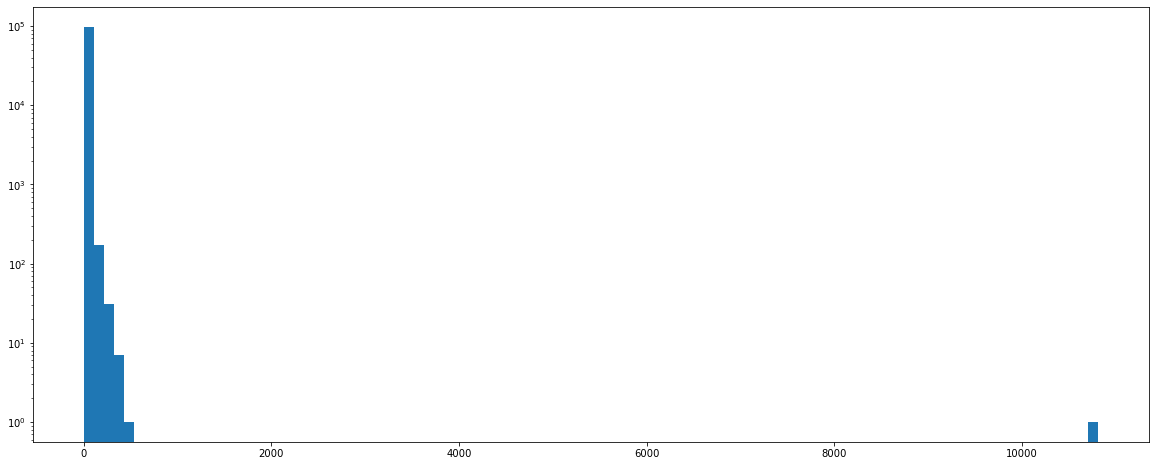

In [47]:
plt.figure(figsize=(20,8))
plt.hist(list_degree_in,log="xy",bins=100);

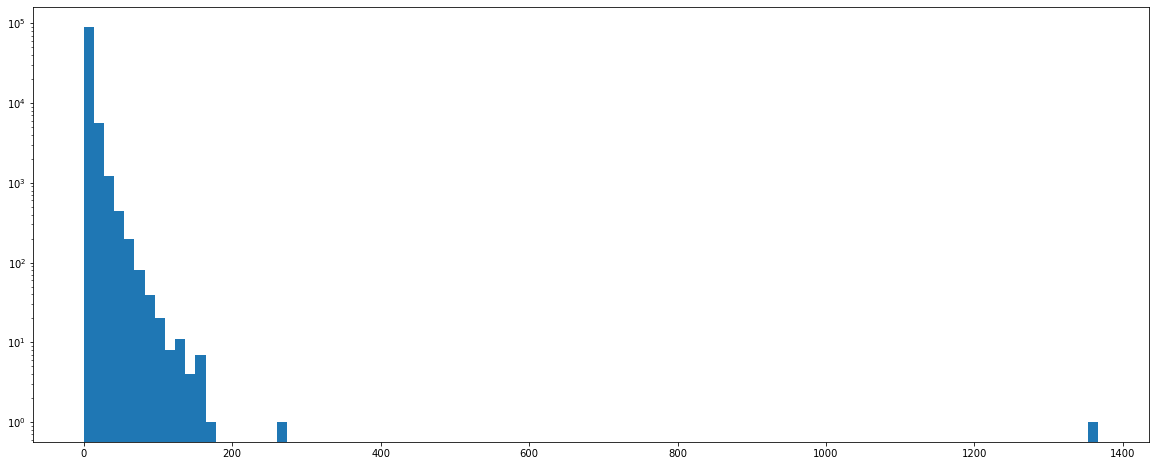

In [48]:
plt.figure(figsize=(20,8))
plt.hist(list_degree_out,log="xy",bins=100);

In [62]:
from collections import deque
def BFS_distances(G,v,inf_distances=True,p=None):
    "we use a standard iterative BFS with a queue to avoid having too many recursive calls"
    inf=float("inf")
    
    q = deque()
    discovered={}
    discovered[v] = 0
    # put starting vertex in the queue
    q.append(v)
    edges_with_distances=[]
    vertices=G.nodes
    while q:
        v = q.popleft()
        
        edges_with_distances.append((v,discovered[v]))
 
        for u in G.neighbors(v):
            if u not in discovered:
                # mark it discovered and push it into queue
                discovered[u] = discovered[v]+1
                q.append(u)
    if inf_distances:
        for v in vertices:
            if v not in discovered:
                edges_with_distances.append((v,inf))
    return edges_with_distances
    

# RQ2 (DA FINIRE)

In [64]:
BFS_distances(G,95)

[(95, 0),
 (1185516, 1),
 (150451, 2),
 (1062563, 2),
 (1178930, 2),
 (1184017, 2),
 (1184695, 2),
 (1761109, 2),
 (1177884, 3),
 (110209, 3),
 (688300, 3),
 (943780, 3),
 (1057618, 3),
 (1058061, 3),
 (1058123, 3),
 (1058832, 3),
 (1059127, 3),
 (1059279, 3),
 (1059658, 3),
 (1060403, 3),
 (1060445, 3),
 (1060529, 3),
 (1060572, 3),
 (1060926, 3),
 (1060995, 3),
 (1061105, 3),
 (1061808, 3),
 (1061851, 3),
 (1061865, 3),
 (1061882, 3),
 (1061891, 3),
 (1061905, 3),
 (1061966, 3),
 (1062107, 3),
 (1062129, 3),
 (1063050, 3),
 (1063517, 3),
 (1063559, 3),
 (1063850, 3),
 (1063900, 3),
 (1064265, 3),
 (1065404, 3),
 (1066682, 3),
 (1163441, 3),
 (1163564, 3),
 (1163693, 3),
 (1174957, 3),
 (1183891, 3),
 (1184225, 3),
 (1240445, 3),
 (1377543, 3),
 (1377636, 3),
 (1551064, 3),
 (1731279, 3),
 (1731281, 3),
 (358617, 3),
 (689637, 3),
 (689640, 3),
 (1053744, 3),
 (1054633, 3),
 (1055075, 3),
 (1057056, 3),
 (1057316, 3),
 (1057884, 3),
 (1058280, 3),
 (1058318, 3),
 (1058392, 3),
 (10603

# RQ3

In [109]:
nx.get_node_attributes(G,"Category")[95]

'Debut_albums'

In [102]:
nx.set_node_attributes(G, inverted_dictionary, name="Category")

In [192]:
def most_central_article(G,category):
    nodes=list(map(int,d_random_cat_page[category]))
    assert len(nodes)>0,"Empty/non-existent category!"
    max_in_degree=list(G.in_degree(nodes))
    return max(max_in_degree,key=lambda x:x[1])

In [195]:
most_central_article(G,'Debut_albums')

(1227839, 13)

In [203]:
p=[95,108,134]
C="Debut_albums"

### This algorithm requires an explaination

In [232]:
def graph_exploration(G,p,C):
    most_central=most_central_article(G,C)[0]
    if most_central not in p:
        p.append(most_central)
    
    new_graph=nx.empty_graph(create_using=nx.DiGraph())
    
    for node1 in p:
        for node2 in p:
            if node1!=node2:
                distances=dict(BFS_distances(G,node1))
                new_graph.add_edge(node1,node2,weight=distances[node2])
    return new_graph

In [233]:
new_graph=graph_exploration(G,p,C)

In [234]:
new_graph.edges

OutEdgeView([(95, 108), (95, 134), (95, 1227839), (108, 95), (108, 134), (108, 1227839), (134, 95), (134, 108), (134, 1227839), (1227839, 95), (1227839, 108), (1227839, 134)])

In [238]:
nx.get_edge_attributes(new_graph,"weight")

{(95, 108): inf,
 (95, 134): 6,
 (95, 1227839): 9,
 (108, 95): inf,
 (108, 134): 5,
 (108, 1227839): 9,
 (134, 95): inf,
 (134, 108): inf,
 (134, 1227839): 8,
 (1227839, 95): inf,
 (1227839, 108): inf,
 (1227839, 134): inf}